In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
import math
from torchsummary import summary
seed=2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

if device == 'cuda':
    torch.cuda.manual_seed(seed)

np.random.seed(seed)
torch.manual_seed(seed)

cpu


In [2]:
image_data = np.load("image_states.npy")
image_data = image_data.reshape(image_data.shape[0], image_data.shape[1], 3, 24, 32)
print("image_data.shape : {}".format(image_data.shape))
joint_data = np.load("joint_states.npy")
joint_data=joint_data[:, :, 3:]
print("joint_data.shape : {}".format(joint_data.shape))
print(np.max(joint_data))
print(np.min(joint_data))

image_data.shape : (100, 160, 3, 24, 32)
joint_data.shape : (100, 160, 14)
1.8002384868885333
-1.7579419829169447


In [3]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, vision_input_data, joint_input_data, joint_target_data):
        self.v_input_data = torch.from_numpy(vision_input_data).float()
        self.j_input_data = torch.from_numpy(joint_input_data).float()
        self.j_target_data = torch.from_numpy(joint_target_data).float()

    def __len__(self):
        return self.v_input_data.shape[0]

    def __getitem__(self, index):
        vision_input_datum = self.v_input_data[index]
        joint_input_data = self.j_input_data[index]
        joint_target_data = self.j_target_data[index]

        return vision_input_datum, joint_input_data, joint_target_data

#np -> np     TO DO :ロボット動かすときには逆操作できるように作ることも大事
def joint_regurarization(joint_data):
    joint_data_mean = np.mean(joint_data)
    joint_data_regurarized = joint_data - joint_data_mean
    mean_regurarized_max = np.max(np.abs(joint_data_regurarized))
    joint_data_regurarized = joint_data_regurarized/mean_regurarized_max
    
    return joint_data_regurarized, joint_data_mean, mean_regurarized_max 

def reverse_joint_regurarization(joint_data_regurarized, joint_data_mean, mean_regurarized_max):
    joint_data_reverse = joint_data_regurarized * mean_regurarized_max
    joint_data_reverse += joint_data_mean

    return joint_data_reverse
 

#def revrese_joint_regurarization(joint_regurarization_data, mean_data):

def create_dataloader(image_data, joint_data, batch_size):
    joint_data, jont_data_mean, mean_regurarized_max = joint_regurarization(joint_data)      

    indeces = [int(image_data.shape[0] * n) for n in [0.4, 0.4+0.1, 0.9]]
    train_image_data1, val_image_data1, train_image_data2, val_image_data2 = np.split(image_data[:, 0:-1, :, :, :], indeces, axis=0)
    train_image_data = np.concatenate([train_image_data1, train_image_data2], axis=0)
    val_image_data = np.concatenate([val_image_data1, val_image_data2], axis=0)

    train_joint_input1, val_joint_input1, train_joint_input2, val_joint_input2 = np.split(joint_data[:, 0:-1, :], indeces, axis=0)
    train_joint_input_data = np.concatenate([train_joint_input1, train_joint_input2], axis=0)
    val_joint_input_data = np.concatenate([val_joint_input1, val_joint_input2], axis=0)

    train_joint_input1, val_joint_input1, train_joint_input2, val_joint_input2 = np.split(joint_data[:, 1:, :], indeces, axis=0)
    train_joint_target_data = np.concatenate([train_joint_input1, train_joint_input2], axis=0)
    val_joint_target_data = np.concatenate([val_joint_input1, val_joint_input2], axis=0)
    

    train_dataset = MyDataset(train_image_data, train_joint_input_data, train_joint_target_data)
    val_dataset = MyDataset(val_image_data, val_joint_input_data, val_joint_target_data)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    
    return train_dataloader, val_dataloader

def visualize_loss(epochs, dict_eachLoss, fig_name):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(dict_eachLoss['train_vae_loss'], linestyle="solid")
    ax.plot(dict_eachLoss['train_joint_loss'], linestyle="dashed")
    ax.plot(dict_eachLoss['train_loss'], linestyle = "dotted")
    ax.plot(dict_eachLoss['val_vae_loss'], linestyle="solid")
    ax.plot(dict_eachLoss['val_joint_loss'], linestyle="dashed")
    ax.plot(dict_eachLoss['val_loss'], linestyle = "dotted")
    ax.set_yscale('log')
    ax.legend(['train_vae_loss * vae_weight', 'train_joint_loss * joint_weight', 'train_loss', 'val_vae_loss * vae_weight', 'val_joint_loss * joint_weight', 'val_loss'],\
              loc='center left', bbox_to_anchor=(1., .5))
    

    ax.set_xlim(0, epochs)
    ax.set_title('each_loss')
    fig.savefig(fig_name + ".png")
    

In [4]:
class Vision_VAE(nn.Module):
    def __init__(self, z_dim, device):
        super(Vision_VAE, self).__init__()
        self.device = device
        self.encoder = VAE_Encoder(z_dim)
        self.decoder = VAE_Decoder(z_dim)
        self.z_dim = z_dim
        self.beta = 1
        self.var = 1e-2

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        y = self.decoder(z)
        return z, y

    def reparameterize(self, mean, var):
        z = (mean + torch.mul(torch.sqrt(torch.exp(var)), torch.normal(mean = 0, std=1, size=mean.shape).to(self.device)))
        return z

    def cal_loss(self, x, criterion = nn.MSELoss()):
        scale_adjust = x.shape[1] * x.shape[2] *x.shape[3]/ self.z_dim
        mean, log_var = self.encoder.forward(x)
        #print("var{}".format(var))
        z = self.reparameterize(mean, log_var)
        y = self.decoder.forward(z)
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        #変分下限Lの最大化　-> -Lの最小化
        reconstruction = criterion(y , x) * scale_adjust/(self.var*2)
        kl = -self.beta * torch.mean(1+log_var- mean**2 - torch.exp(log_var))/2#beta_vae
        #print("reconstruction : {}".format(reconstruction.shape))
        #print("KL : {}".format(kl.shape))
        loss =  reconstruction + kl
        return loss    

class VAE_Encoder(nn.Module):
    def __init__(self, z_dim):
        super(VAE_Encoder, self).__init__()
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.Mish(),
            nn.BatchNorm2d(num_features = 8),
        )#->(8, 24, 32)

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
        )#->(16,12, 16)

        self.cnn_layer3 = nn.Sequential(
            nn.Conv2d(in_channels =16, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
        )#->(32, 5, 7)
        
        self.mean_layer = nn.Sequential(
            nn.Linear(32*5*7, 200),
            nn.Mish(),
            nn.BatchNorm1d(num_features=200),
            nn.Linear(200, z_dim)
        )   
        self.log_var_layer = nn.Sequential(
            nn.Linear(32*5*7, 64),
            nn.Mish(),
            nn.BatchNorm1d(num_features=64),
            nn.Linear(64, z_dim)
        )    

    def forward(self, x):
        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)
        out = self.cnn_layer3(out)
        out = out.view(out.size(0), -1)

        mean = self.mean_layer(out)
        log_var = self.log_var_layer(out)

        return mean, log_var

class VAE_Decoder(nn.Module):
    def __init__(self, z_dim):
        super(VAE_Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, 100)
        self.fc2 = nn.Linear(100, 32*3*4)

        self.cnn_layer1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.Mish(),
            nn.BatchNorm2d(num_features = 16)
        )#->(16, 6, 8)

        self.cnn_layer2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, stride=2,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 8),
        )#->(8, 12, 16)

        self.cnn_layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=4, stride=2, padding=1),
        )#->(3, 24, 32)


    def forward(self, z):
        out = self.fc1(z)
        out = torch.relu(out)
        out = self.fc2(out)
        out = torch.relu(out)
        out = out.view(-1, 32, 3, 4)
        out = self.cnn_layer1(out)
        out = self.cnn_layer2(out)
        out = self.cnn_layer3(out)
        out = torch.sigmoid(out)
        
        return out
    
class RNN_VisionVAE(nn.Module):
    def __init__(self, input_size , hidden_size, num_layer, z_dim, device):
        super(RNN_VisionVAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.z_dim = z_dim
        self.vision_vae = Vision_VAE(z_dim, device)
        self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size,\
                          num_layers= num_layer, batch_first=True)
        self.fc_output_j = nn.Linear(hidden_size, 14)
        
        self.weight_vae = 10e2
        self.weight_joint = 10e4
       

    def forward(self,i, j_pre):
        z_i, y = self.vision_vae.forward(i)
        z_i = z_i.reshape(j_pre.shape[0], j_pre.shape[1], -1)#z_iの形を(データ数, time_step, 潜在表現の次元)にする
        x = torch.concat([z_i, j_pre], dim=2)
        x, _ = self.rnn(x, None)
        x = self.fc_output_j(x)
        j_next = torch.sigmoid(x)
        
        return j_next

    def autoregress(self, i, j_pre, h):
        z_i, y = self.vision_vae.forward(i)
        
        x = torch.concat([z_i, j_pre], dim=1).reshape(1, -1, 14+self.z_dim)
        x, h = self.rnn(x, h)
        x = self.fc_output_j(x)
        j_next = torch.sigmoid(x)
        
        return j_next, h
    
    def cal_loss(self, i, j_pre,j_target, criterion = nn.MSELoss()):
        
        z_i, y = self.vision_vae.forward(i)
        z_i = z_i.reshape(j_pre.shape[0], j_pre.shape[1], -1)#z_iの形を(データ数, time_step, 潜在表現の次元)にする
        x = torch.concat([z_i, j_pre], dim=2)  
        x, _ = self.rnn(x, None)
        x= self.fc_output_j(x)
        j_next = torch.sigmoid(x)
        
        loss_vae = self.weight_vae * self.vision_vae.cal_loss(i)
        loss_j = self.weight_joint*criterion(j_target, j_next)
        loss = loss_vae + loss_j

        return loss, loss_vae, loss_j

#To Do : LSTMのモデルを試す
class LSTM_VisionVAE(nn.Module):
    def __init__(self, input_size , hidden_size, num_layer, z_dim, device):
        super(LSTM_VisionVAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.z_dim = z_dim
        self.vision_vae = Vision_VAE(z_dim, device)
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size,\
                          num_layers= num_layer, batch_first=True)
        self.fc_output_j = nn.Linear(hidden_size, 14)
        
        self.weight_vae = 10e2
        self.weight_joint = 10e4
       

    def forward(self,i, j_pre):
        z_i, y = self.vision_vae.forward(i)
        z_i = z_i.reshape(j_pre.shape[0], j_pre.shape[1], -1)#z_iの形を(データ数, time_step, 潜在表現の次元)にする
        x = torch.concat([z_i, j_pre], dim=2)
        x, _ = self.lstm(x, None)
        x = self.fc_output_j(x)
        j_next = torch.sigmoid(x)
        
        return j_next, y

    def autoregress(self, i, j_pre, h, c):
        z_i, y = self.vision_vae.forward(i)
        
        x = torch.concat([z_i, j_pre], dim=1).reshape(1, -1, 14+self.z_dim)
        if h == None and c == None:
            state = None
        else: state =(h, c)    
        x, (h, c) = self.lstm(x, state)
        x = self.fc_output_j(x)
        j_next = torch.sigmoid(x)
        
        return j_next, h, c
    
    def cal_loss(self, i, j_pre,j_target, criterion = nn.MSELoss()):
        
        z_i, y = self.vision_vae.forward(i)
        z_i = z_i.reshape(j_pre.shape[0], j_pre.shape[1], -1)#z_iの形を(データ数, time_step, 潜在表現の次元)にする
        x = torch.concat([z_i, j_pre], dim=2)  
        x, _ = self.lstm(x, None)
        x= self.fc_output_j(x)
        j_next = torch.sigmoid(x)
        
        loss_vae = self.weight_vae * self.vision_vae.cal_loss(i)
        loss_j = self.weight_joint*criterion(j_target, j_next)
        loss = loss_vae + loss_j

        return loss, loss_vae, loss_j
 

In [5]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=100, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [6]:
# earlyStopping、datalaoder
def train(model, optimizer, epochs, batch_size, lr, image_data, joint_data, loss_fig_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_dataloader, val_dataloader = create_dataloader(image_data, joint_data, batch_size)
    torch.manual_seed(seed=seed)
    optimizer = optimizer(model.parameters(), lr=lr)
    early_stopping = EarlyStopping()
    model = model.to(device)

    #勾配クリッピング
    #grad_clip = 1

    loss_dict = {'train_loss' : [], 'train_vae_loss' : [], 'train_joint_loss' : [], 'val_loss' : [], 'val_vae_loss' : [], 'val_joint_loss' : [],}

    for epoch in range(epochs):
        
        
        train_loss = 0
        train_vae_loss = 0
        train_joint_loss = 0
        
        for image_inputs, joint_inputs, joint_targets in train_dataloader:
            model.train()
            image_inputs, joint_inputs, joint_targets = image_inputs.to(device), joint_inputs.to(device), joint_targets.to(device)
            image_inputs = image_inputs.reshape(-1, 3, 24, 32)
            loss, _, _ = model.cal_loss(image_inputs, joint_inputs, joint_targets)
            #print("loss.shpe {}".format(loss.shape))
            optimizer.zero_grad()
            loss.backward()
            #nn.utils.clip_grad_value_(parameters=model.parameters(), clip_value=grad_clip)
            optimizer.step()    

            model.eval()
            with torch.no_grad():
                each_train_loss, each_vae_loss, each_joint_loss= model.cal_loss(image_inputs, joint_inputs, joint_targets)
                train_loss += each_train_loss.item()
                train_vae_loss += each_vae_loss.item()
                train_joint_loss += each_joint_loss.item()

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_vae_loss = 0
            val_joint_loss = 0
            for image_inputs, joint_inputs, joint_targets in val_dataloader:
                image_inputs, joint_inputs, joint_targets = image_inputs.to(device), joint_inputs.to(device), joint_targets.to(device)
                image_inputs = image_inputs.reshape(-1, 3, 24, 32)
                print("image_inputs_val : {}".format(image_inputs.shape))
                
                each_val_loss, each_vae_loss, each_joint_loss = model.cal_loss(image_inputs, joint_inputs, joint_targets)
                val_loss += each_val_loss.item()
                val_vae_loss += each_val_loss.item()
                val_joint_loss += each_joint_loss.item()


        print("Epoch: {}/{} ".format(epoch + 1, epochs),
            "Train_loss: {} ".format(train_loss/len(train_dataloader)),
            "Train_vae_loss: {} ".format(train_vae_loss/len(train_dataloader)),
            "Train_joint_loss: {} ".format(train_joint_loss/len(train_dataloader)),
            "Val_loss: {}".format(val_loss/len(val_dataloader)),
            "Val_vae_loss : {}".format(val_vae_loss/len(val_dataloader)),
            "Val_joint_loss : {}".format(val_joint_loss/len(val_dataloader)))

        loss_dict["train_loss"].append(train_loss/len(train_dataloader))
        loss_dict["train_vae_loss"].append(train_vae_loss/len(train_dataloader))
        loss_dict["train_joint_loss"].append(train_joint_loss/len(train_dataloader))
        loss_dict["val_loss"].append(val_loss/len(val_dataloader))
        loss_dict["val_vae_loss"].append(val_vae_loss/len(val_dataloader))
        loss_dict["val_joint_loss"].append(val_joint_loss/len(val_dataloader))

        if math.isnan(val_loss) and epoch>0:
            break
        
        if epoch > 5000:
            early_stopping(val_loss/len(val_dataloader), model) # 最良モデルならモデルパラメータ保存
            if early_stopping.early_stop: 
                        # 一定epochだけval_lossが最低値を更新しなかった場合、ここに入り学習を終了
                break   

    visualize_loss( epoch,loss_dict,"image/"+loss_fig_name+".png")
    return epoch

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer1 = torch.optim.Adam
optimizer2 = torch.optim.RAdam

batch_size = 20
epoch = 0

# model_1 = RNN_VisionVAE(input_size=14+4, hidden_size=20, num_layer=1 ,z_dim =4 , device = device).to(device)
# epoch = train(model=model_1, optimizer=optimizer1, epochs=8000, batch_size = batch_size,\
#           lr=0.001, image_data=image_data, joint_data=joint_data, loss_fig_name="fromepoch5000_RNN")
     
# path = "checkpoint.pt"
# model = RNN_VisionVAE(input_size=14+4, hidden_size=20, num_layer=1 ,z_dim = 4, device = 'cpu')
# model_1.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
     
# path = "learned_model/fromepoch5000_RNN.pth"
# torch.save(model_1.to('cpu').state_dict(), path)

model_2 = LSTM_VisionVAE(input_size=14+4, hidden_size=20, num_layer=1 ,z_dim =4 , device = device).to(device)
epoch = train(model=model_2, optimizer=optimizer1, epochs=8000, batch_size = batch_size,\
          lr=0.001, image_data=image_data, joint_data=joint_data, loss_fig_name="epoch5000_state_LSTM")
     
path = "checkpoint.pt"
model = LSTM_VisionVAE(input_size=14+4, hidden_size=20, num_layer=1 ,z_dim = 4, device = 'cpu')
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
     
path = "learned_model/poch5000_state_LSTM.pth"
torch.save(model_2.to('cpu').state_dict(), path)

KeyboardInterrupt: 

In [49]:
path = "checkpoint.pt"
model = LSTM_VisionVAE(input_size=14+4, hidden_size=20, num_layer=1 ,z_dim = 4, device = 'cpu')
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
     
path = "/home/igari/igari/Kadai4/learned_model/fromepoch5000_LSTM.pth"
torch.save(model.to('cpu').state_dict(), path)

In [8]:
path = "/home/igari/igari/Kadai4/learned_model/fromepoch5000_LSTM.pth"
model = LSTM_VisionVAE(input_size=14+4, hidden_size=20, num_layer=1 ,z_dim = 4, device = 'cpu')
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

FileNotFoundError: [Errno 2] No such file or directory: '/home/igari/igari/Kadai4/learned_model/fromepoch5000_LSTM.pth'

In [24]:
model = RNN_VisionVAE(input_size=14+4, hidden_size=20, num_layer=1 ,z_dim = 4, device = 'cpu')
summary(model, [(3, 24, 32), (1, 14)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 24, 32]             224
              Mish-2            [-1, 8, 24, 32]               0
       BatchNorm2d-3            [-1, 8, 24, 32]              16
            Conv2d-4           [-1, 16, 12, 16]           1,168
              ReLU-5           [-1, 16, 12, 16]               0
       BatchNorm2d-6           [-1, 16, 12, 16]              32
            Conv2d-7             [-1, 32, 5, 7]           4,640
              ReLU-8             [-1, 32, 5, 7]               0
       BatchNorm2d-9             [-1, 32, 5, 7]              64
           Linear-10                  [-1, 200]         224,200
             Mish-11                  [-1, 200]               0
      BatchNorm1d-12                  [-1, 200]             400
           Linear-13                    [-1, 4]             804
           Linear-14                   

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [73]:
#x -> (encoder) -> z_latent -> (decoder) -> y
#16000のデータ化から、ランダムにデータxを１０個生成してx,yを比較
def generate_xy_Image(model, image_data, fig_name):
    device = 'cpu'
    image_data = image_data.reshape(-1, 3, 24, 32) #(100, 160 , )->(16000)にする
    image_data_torch = torch.from_numpy(image_data)
    image_data_torch = image_data_torch.to(device)

    inputs, outputs = genrate_random_inputAndReconst(model, image_data_torch)

    #入力xの表示(10個分)
    input_images =inputs.to(device).detach().numpy().copy()
    print("input_image")
    print(input_images.shape)
    print(np.min(input_images))
    print(np.max(input_images))
    for i, image in enumerate(input_images):
        plt.title("original")
        plt.subplot(2, 5, i+1)
        plt.imshow(image.reshape(24, 32, 3))
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("image/inputs"+fig_name+".png")

    #出力yの表示(10個)
    output_images = (outputs).to(device).detach().numpy().copy()
    print("renconst_image")
    print(output_images.shape)
    print(np.min(output_images))
    print(np.max(output_images))
    for i, image in enumerate(output_images):
        plt.title("reconst")
        plt.subplot(2, 5, i+1)
        image = image.reshape(24, 32, 3)
        plt.imshow(image)
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("image/recon" + fig_name + ".png")     

def genrate_random_inputAndReconst(model, image_data_torch):
    device =  "cpu"

    #入力データを2で割って学習させたので、画像の生成時には2をかけて元に戻す
    image_data_tensor = image_data_torch.clone()
    image_data_tensor = image_data_tensor.reshape(-1, 3, 24, 32)
    inputs = torch.zeros((10, 3, 24, 32))
    outputs = torch.zeros((10, 3, 24, 32))

    #xをランダムに生成
    torch.manual_seed(seed=2)
    random_index = torch.randint(low=0, high=16000, size=(10,))
    for i in range(10):
        input = image_data_tensor[random_index[i]]
        inputs[i] = input
        
    #yを求める    
    model.eval()
    with torch.no_grad():
        model = model.to(device)
        inputs = inputs.to(device)
        _, outputs = model.vision_vae.forward(inputs)

    return inputs, outputs    

input_image
(10, 3, 24, 32)
0.0
1.0
renconst_image
(10, 3, 24, 32)
0.03788901
0.99908674


/home/igari/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


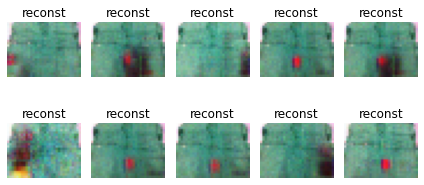

In [74]:

generate_xy_Image(model, image_data=image_data, fig_name="reconst_image")

In [75]:
#RNN用
def test_predict_joint_closed_RNN(model, image_data, joint_data):#model : RNN_vision_vae
    image_data_tensor = torch.from_numpy(image_data).clone()
    joint_data_tensor = torch.from_numpy(joint_data).clone()

    #TO DO : 右左一個ずつ生成したほうがいい
    #100データのうちランダムにn個生成する
    torch.manual_seed(seed=2)
    n = 2
    joint_predictions = torch.zeros((n, 159, 14))
    random_index = torch.randint(low=0, high=100, size=(n,))
    inputs_image = torch.zeros((n, 160, 3, 24, 32))
    inputs_joint = torch.zeros((n, 160, 14))

    for i in range(n):
        input_image = image_data_tensor[random_index[i]]
        input_joint = joint_data_tensor[random_index[i]]

        inputs_image[i] = input_image 
        inputs_joint[i] = input_joint

    joint_input_datum = inputs_joint[:, 0, :]
    joint_target_data = inputs_joint[:, 1 :, :] 
    image_input_data = inputs_image[:, 0:-1, :, :, :]

    print(inputs_image[:,0, :, :, :].reshape(-1, 3, 24, 32).shape)
    
    joint_prediction, h = model.autoregress(image_input_data[:,0, :, :, :].reshape(-1, 3, 24, 32), joint_input_datum, h=None)
    joint_predictions[:, 0, :] = joint_prediction
    for i in range(1, image_input_data.shape[1]):
        joint_prediction, h = model.autoregress(image_input_data[:,i, :, :].reshape(-1, 3, 24, 32), joint_predictions[:, i-1, :], h)
        joint_predictions[:, i, :] = joint_prediction

    visualize_joint_test(joint_predictions, joint_target_data, data_num=n)    


#LSTM用
def test_predict_joint_closed_LSTM(model, image_data, joint_data):#model : LSTM_vision_vae
    image_data_tensor = torch.from_numpy(image_data).clone()
    joint_data_tensor = torch.from_numpy(joint_data).clone()

    #TO DO : 右左一個ずつ生成したほうがいい
    #100データのうちランダムにn個生成する
    torch.manual_seed(seed=2)
    n = 2
    joint_predictions = torch.zeros((n, 159, 14))
    random_index = torch.randint(low=0, high=100, size=(n,))
    inputs_image = torch.zeros((n, 160, 3, 24, 32))
    inputs_joint = torch.zeros((n, 160, 14))

    for i in range(n):
        input_image = image_data_tensor[random_index[i]]
        input_joint = joint_data_tensor[random_index[i]]

        inputs_image[i] = input_image 
        inputs_joint[i] = input_joint

    joint_input_datum = inputs_joint[:, 0, :]
    joint_target_data = inputs_joint[:, 1 :, :] 
    image_input_data = inputs_image[:, 0:-1, :, :, :]

    print(inputs_image[:,0, :, :, :].reshape(-1, 3, 24, 32).shape)
    
    joint_prediction, h, c = model.autoregress(inputs_image[:,0, :, :, :].reshape(-1, 3, 24, 32), joint_input_datum,  None, None)
    joint_predictions[:, 0, :] = joint_prediction
    for i in range(1, image_input_data.shape[1]):
        joint_prediction, h, c = model.autoregress(inputs_image[:,i, :, :].reshape(-1, 3, 24, 32), joint_predictions[:, i-1, :], h, c)
        joint_predictions[:, i, :] = joint_prediction

    visualize_joint_test(joint_predictions, joint_target_data, data_num=n)  



def test_predict_joint_open(model, image_data, joint_data):#model : RNN_vision_vae, LSTM_vision_vae

    image_data_tensor = torch.from_numpy(image_data).clone()
    joint_data_tensor = torch.from_numpy(joint_data).clone()

    #TO DO : 右左一個ずつ生成したほうがいいかも
    #100データのうちランダムにn個生成する
    torch.manual_seed(seed=2)
    n = 2
    #joint_predictions = torch.zeros((n, 159, 14))
    random_index = torch.randint(low=0, high=100, size=(n,))
    inputs_image = torch.zeros((n, 160, 3, 24, 32))
    inputs_joint = torch.zeros((n, 160, 14))
    for i in range(n):
        input_image = image_data_tensor[random_index[i]]
        joint_datum = joint_data_tensor[random_index[i]]

        inputs_image[i] = input_image 
        inputs_joint[i] = joint_datum

    joint_input_data = inputs_joint[:, 0:-1, :]
    joint_target_data = inputs_joint[:, 1 :, :] 
    image_inputs_data = inputs_image[:, 0:-1, :, :, :]

    joint_predictions = model.forward(image_inputs_data.reshape(-1, 3, 24, 32), joint_input_data)
    

    #TO DO : この関数を作る
    visualize_joint_test(joint_predictions, joint_target_data, data_num = n)



def visualize_joint_test(joint_predictions, joint_target_data, data_num):
    joint_predictions = joint_predictions.detach().cpu().numpy()
    joint_target_data = joint_target_data.detach().cpu().numpy()

    legend_label = []
    for i in range(data_num):
        legend_label.append('pred_data{}'.format(i+1))
        legend_label.append('target_data{}'.format(i+1))



    fig = plt.figure(figsize=(20, 12))
    plt.subplots_adjust(hspace=1, wspace=0.3)
    for i  in range(data_num):
        for j in range(14):
            ax = fig.add_subplot(7, 2, j+1)
            ax.set_xlim(1, 160)
            # ax.scatter(joint_predictions[i, :, j])
            # ax.scatter(joint_target_data[i, :, j])
            ax.plot(joint_predictions[i, :, j])
            ax.plot(joint_target_data[i, :, j])
            ax.legend(legend_label, loc='center left', bbox_to_anchor=(1., .5))
        
            ax.set_xlabel('dim {}'.format(j+1))
    plt.savefig("compare_predictions_targets_data_num={}".format(i)) 
         
      

torch.Size([2, 3, 24, 32])


/home/igari/.local/lib/python3.6/site-packages/ipykernel_launcher.py:121: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/igari/.local/lib/python3.6/site-packages/ipykernel_launcher.py:121: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/igari/.local/lib/python3.6/site-packages/ipykernel_launcher.py:121: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier inst

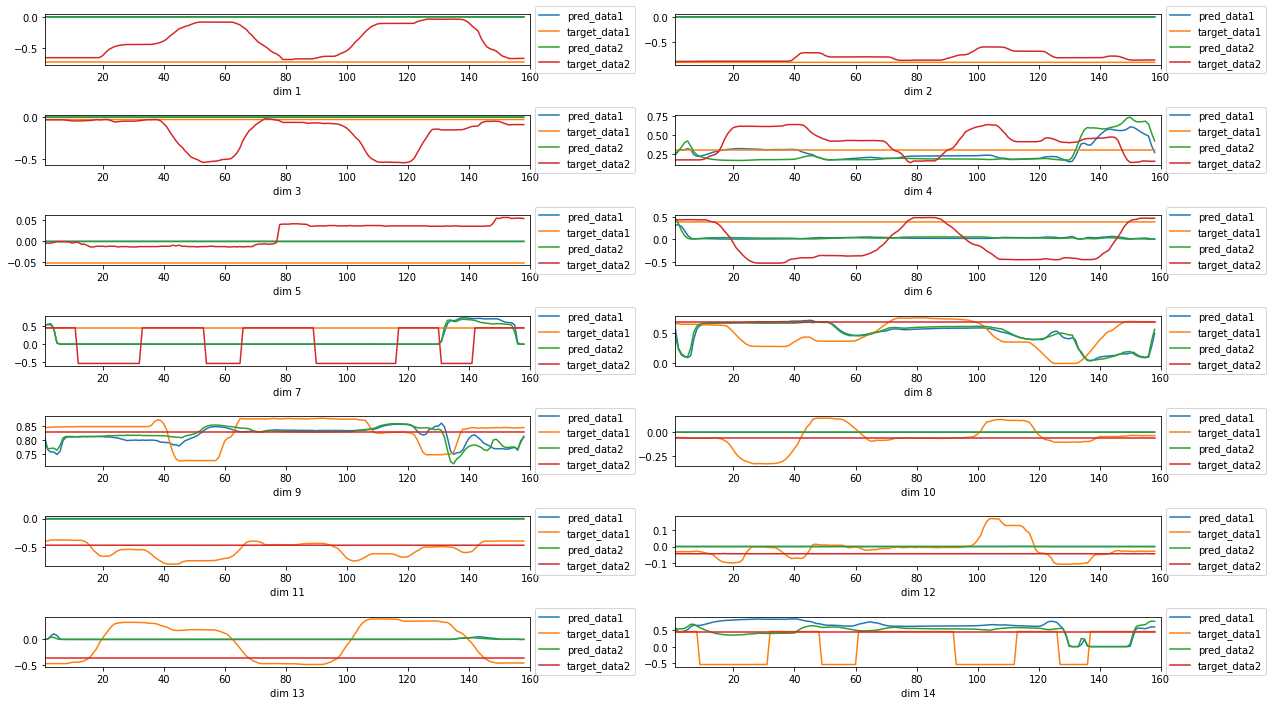

In [76]:
def joint_regurarization(joint_data):
    joint_data_mean = np.mean(joint_data)
    joint_data_regurarized = joint_data - joint_data_mean
    mean_regurarized_max = np.max(np.abs(joint_data_regurarized))
    joint_data_regurarized = joint_data_regurarized/mean_regurarized_max
    
    return joint_data_regurarized, joint_data_mean, mean_regurarized_max

joint_data_regurarized, joint_data_mean, mean_regurarized_max = joint_regurarization(joint_data)
test_predict_joint_closed_LSTM(model, image_data, joint_data_regurarized)

/home/igari/.local/lib/python3.6/site-packages/ipykernel_launcher.py:121: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/igari/.local/lib/python3.6/site-packages/ipykernel_launcher.py:121: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/igari/.local/lib/python3.6/site-packages/ipykernel_launcher.py:121: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier inst

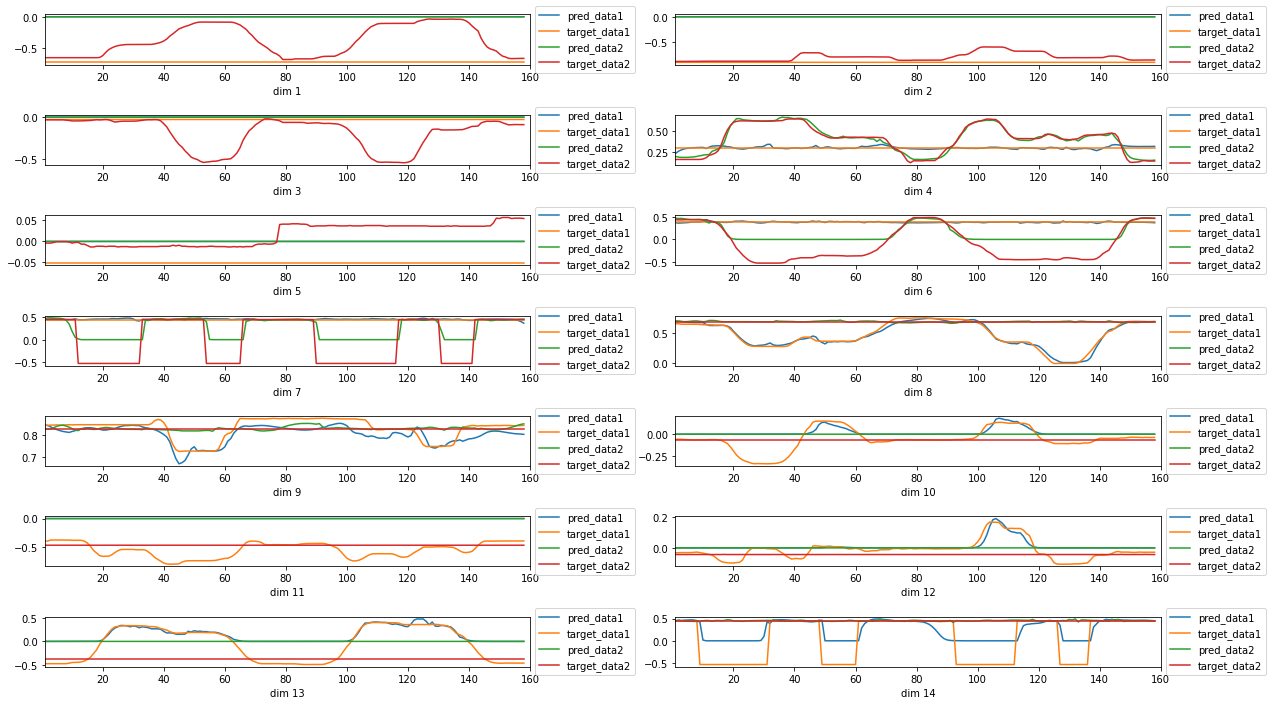

In [77]:
test_predict_joint_open(model, image_data, joint_data_regurarized)

In [78]:
#@潜在表現の一次元、二次元表示

#data(50, 160, 2) -> return latent(160, 2)
def cal_step_meanlatent(data):
    z_mean_latent = torch.zeros(data.shape[1], 2)
    data = torch.from_numpy(data)

    for i in range(data.shape[1]):
        zs_step_mean = torch.mean(data[:, i, :], axis = 0).reshape([-1, 2])           
        z_mean_latent[i] = zs_step_mean

    return z_mean_latent#(160, 2)      


def cal_task_mean_latent(model, image_data):
    image_data = image_data.reshape(image_data.shape[0]*image_data.shape[1], 3, 24, 32)
    model.eval()
    image_data = torch.from_numpy(image_data).float()
    image_data = image_data.to('cpu')
    with torch.no_grad():
        z_latent, _ = model.vision_vae.forward(image_data)#(16000, 2)z_i, y = self.vision_vae.forward(i)

    z_latent_pca, explained_variance_ratio = pca(z_latent, n_components=2)
    left_task_z_pca = z_latent_pca[:int(z_latent_pca.shape[0]/2), :]#(8000, 2)
    right_task_z_pca = z_latent_pca[int(z_latent_pca.shape[0]/2) :, :]#(8000, 2)
    left_task_z_pca = left_task_z_pca.reshape(50, 160, 2)
    right_task_z_pca = right_task_z_pca.reshape(50, 160, 2)
    print("z_left_latent_pca")

    left_task_mean_latent = cal_step_meanlatent(left_task_z_pca)
    right_task_mean_latent = cal_step_meanlatent(right_task_z_pca)
    
    return left_task_mean_latent, right_task_mean_latent



def pca(z, n_components):
    pca = PCA(n_components).fit(z)
    return pca.fit_transform(z), pca.explained_variance_ratio_


#散布図にカラーマップ、ラベルをつけたりする
# https://python-academia.com/matplotlib-scatter/
#scatterとplotの二つを同時に適用できる
def visualize_2task_pca(left_pca,right_pca,  fig_name):
    labels = [str(10*num) for num in range(1,int(left_pca.shape[0]/10)+1)]
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(left_pca[:, 0], left_pca[:, 1])
    ax.scatter(right_pca[:, 0], right_pca[:, 1])
    ax.plot(left_pca[:, 0], left_pca[:, 1])
    ax.plot(right_pca[:, 0], right_pca[:, 1])
    ax.set_xlabel("first_pricipal_component")
    ax.set_ylabel("second_pricipal_component")
    ax.legend(['left_task', 'right_task'])
    ax.set_title('pca')

    for i, label in enumerate(labels):
        ax.text(left_pca[10*i, 0], left_pca[10*i, 1],label)
        ax.text(right_pca[10*i, 0], right_pca[10*i, 1],label)
    plt.savefig(fig_name + ".png")

def visualize_2task_time_horizontal(task1_pca1, task_pca2, fig_name):
    fig = plt.figure()
    plt.subplots_adjust(hspace=0.6)

    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_title("first_pricipal_component")
    ax1.set_xlim(0, 160)
    # ax1.scatter(task1_pca1[:, 0])
    # ax1.scatter(task_pca2[:, 0])
    ax1.plot(task1_pca1[:, 0])
    ax1.plot(task_pca2[:, 0])
    ax1.legend(['task1', 'task2'])

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_title("second_pricipal_component")
    ax2.set_xlim(0, 160)
    # ax2.scatter(task1_pca1[:, 1])
    # ax2.scatter(task_pca2[:, 1])
    ax2.plot(task1_pca1[:, 1])
    ax2.plot(task_pca2[:, 1])
    ax2.legend(['task1', 'task2'])

    plt.savefig(fig_name + "time_step.png")



z_left_latent_pca


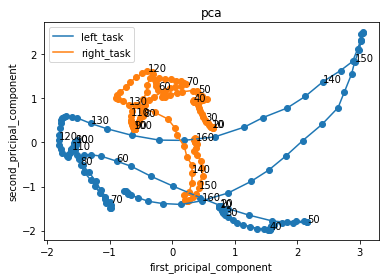

In [79]:
left_pca, right_pca = cal_task_mean_latent(model, image_data)
visualize_2task_pca(left_pca, right_pca, "z_latent_2dim_pca")

In [80]:
def visualize_z_latent_timestep(zs_latent_pca, data_num, explained_variance_ratio):

    legend_label = ['data{}'.format(i+1) for i in range(data_num)]

    fig = plt.figure()
    plt.subplots_adjust(hspace=1, wspace=0.3)
    for i  in range(data_num):
        for j in range(2):
            ax = fig.add_subplot(2, 1, j+1)
            ax.set_xlim(1, 160)
            ax.plot(zs_latent_pca[i,:,  j])
            ax.plot(zs_latent_pca[i,:,  j])
            ax.set_xlabel("{}th_pricipal_component(variance_ratio : {})".format(j+1, explained_variance_ratio[j]))
            
            ax.legend(legend_label, loc='center left', bbox_to_anchor=(1., .5))
    plt.savefig("latent_timestep_data_num={}".format(i))

def cal_task_latent(model, image_data, data_num):
    image_data = image_data.reshape(image_data.shape[0]*image_data.shape[1], 3, 24, 32)
    model.eval()
    image_data = torch.from_numpy(image_data).float()
    image_data = image_data.to('cpu')
    with torch.no_grad():
        z_latent, _ = model.vision_vae.forward(image_data)#(16000, z_dim)

    z_latent_pca, explained_variance_ratio = pca(z_latent, n_components=2)#(16000, 2)
    z_latent_pca = z_latent_pca.reshape(100, 160, 2)

    n = data_num
    #joint_predictions = torch.zeros((n, 159, 14))
    random_index = np.random.randint(low=0, high=100, size=(n,))
    zs_latent_timestep = np.zeros((n, 160, 2))

    for i in range(n):
        z_latent = z_latent_pca[random_index[i]]
        zs_latent_timestep[i] = z_latent

    visualize_z_latent_timestep(zs_latent_timestep, data_num = n, explained_variance_ratio=explained_variance_ratio)  
   

/home/igari/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/igari/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/igari/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments 

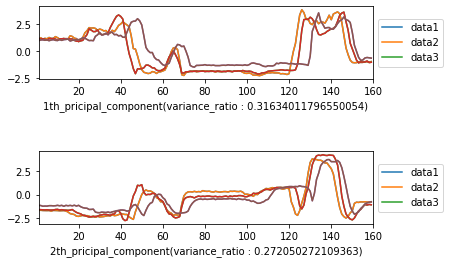

In [81]:
cal_task_latent(model, image_data, 3)